In [2]:
### IMPORTS
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip

%matplotlib inline

In [4]:
### FEATURE EXTRACTION FUNCTIONS
def convert_color(img, color_space='RGB'):
    # Convert to color space if different from RGB
    if color_space != 'RGB':
        to_color = getattr(cv2, 'COLOR_RGB2'+color_space)
        conv_image = cv2.cvtColor(img, to_color)
    else:
        conv_image = np.copy(img) 
    return conv_image

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Histogram of each channel separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return feature vector
    return hist_features

def bin_spatial(img, size=(32, 32)):
    # Resize
    image = cv2.resize(img, size)
    # Feature vector
    features = image.ravel()
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm="L2-Hys")
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec,
                       block_norm="L2-Hys")
        return features
    
def extract_features(img_paths, color_space='RGB',
                     png2jpg = True,
                     spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),
                     pix_per_cell = 8, cell_per_block = 2, orient = 9, hog_channel=0,
                     spatial_feat = True, hist_feat = True, hog_feat = True):
    
    # Create a list to append feature vectors to
    features = []
    
    # for each image path
    for path in img_paths:
        # Read images
        image = mpimg.imread(path)
        # Convert to 0 - 255 image (jpg format)
        if png2jpg:
            image = (image*255).astype(np.uint8)
        # Convert to color space if different from RGB
        if color_space != 'RGB':
            to_color = getattr(cv2, 'COLOR_RGB2'+color_space)
            feature_image = cv2.cvtColor(image, to_color)
        else:
            feature_image = np.copy(image)
        
        # Single image features
        img_features = []
        # Spatial color features
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        # Color histogram
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        # Hog
        if hog_feat:
            hog_features = []
            if hog_channel == 'ALL':
                channels = list(range(feature_image.shape[2]))
            else:
                channels = [hog_channel]                
            for channel in channels:                     
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)   
            img_features.append(hog_features)
        
        # Concatenate features and append to feature vector
        features.append(np.concatenate(img_features))
    return features

### Train classifier

In [5]:
### LOAD CAR + NON CARS IMAGES (PATHS TO)
car_dirname = ['data-set/vehicles/KITTI_extracted/','data-set/vehicles/GTI_Far/'
               ,'data-set/vehicles/GTI_MiddleClose/','data-set/vehicles/GTI_Left/','data-set/vehicles/GTI_Right/']
notcar_dirname = ['data-set/non-vehicles/Extras/','data-set/non-vehicles/GTI/']

cars = []
for dirname in car_dirname:
    cars.extend(glob.glob(dirname+'*.*'))

notcars = []
for dirname in notcar_dirname:
    notcars.extend(glob.glob(dirname+'*.*'))

In [79]:
### EXTRACT FEATURES
spatial = 32
histbin = 32
histrange=(0, 256)

car_features = extract_features(cars, color_space='YCrCb',
                                png2jpg = True,
                                spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=histrange,
                                pix_per_cell = 8, cell_per_block = 2, orient = 9, hog_channel='ALL',
                                spatial_feat = True, hist_feat = True, hog_feat = True)
notcar_features = extract_features(notcars, color_space='YCrCb',
                                   png2jpg = True,
                                   spatial_size=(spatial, spatial),
                                   hist_bins=histbin, hist_range=histrange,
                                   pix_per_cell = 8, cell_per_block = 2, orient = 9, hog_channel='ALL',
                                   spatial_feat = True, hist_feat = True, hog_feat = True)

In [80]:
### SCALE FEATURES
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

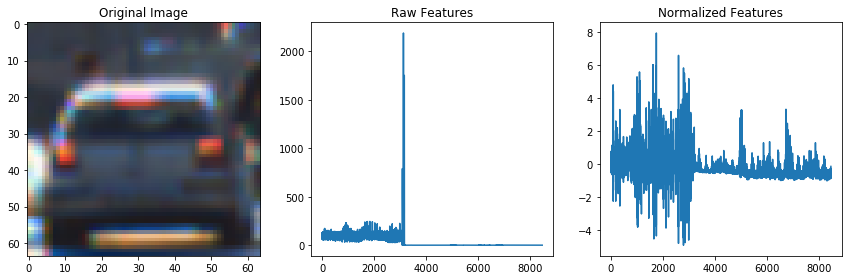

In [81]:
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [82]:
### DEFINE LABELS VECTOR
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [83]:
### TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2)

In [84]:
### FIT SVC CLASSIFIER
linear_svc = svm.LinearSVC()
linear_svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [85]:
### Accuracy on the test set
print(accuracy_score(y_test, linear_svc.predict(X_test)))

0.988457207207


### Vehicle detection

In [86]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block, hog_channels,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, 'YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channels == 'ALL':
        channels = [0,1,2]
    else:
        channels = [hog_channels]
    
    full_hog_features = []
    for ch_id in channels:
        chx = ctrans_tosearch[:,:,ch_id]
        full_hog_features.append(get_hog_features(chx, orient, pix_per_cell, cell_per_block, feature_vec=False))
    
    # list to store features and coordinates of each window
    test_features = []
    test_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_features = []
            for ch_id in channels:
                full_hog = full_hog_features[ch_id]
                hog_featx = full_hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features.append(hog_featx)
            hog_features = np.hstack(hog_features)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # save features
            test_features.append(np.hstack((spatial_features, hist_features, hog_features)))
            
            # and windows
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            test_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+ystart+win_draw)))
          
            
    test_features = np.array(test_features)
    test_windows = np.array(test_windows)
            
    # Scale features and make a prediction
    test_features = X_scaler.transform(test_features)    
    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
    test_prediction = svc.predict(test_features)
    
    # Select positive windows
    positive_windows = test_windows[test_prediction == 1]

    
    return positive_windows

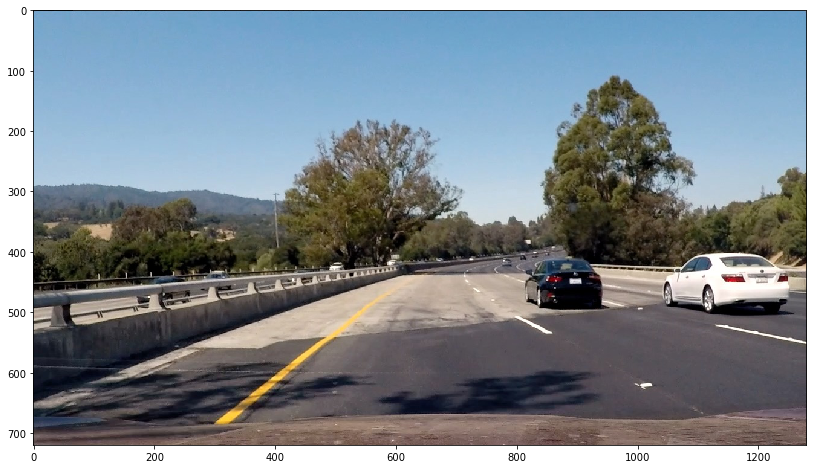

In [87]:
# Test images
img_path = 'test_images/test4.jpg'
img = mpimg.imread(img_path)
fig, (ax1) = plt.subplots(1, figsize=(16,8))
ax1.imshow(img)

Total time: 1.2923331260681152


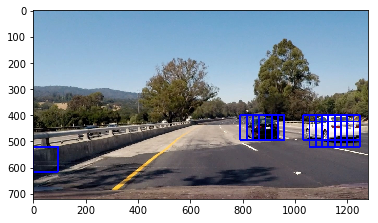

In [88]:
draw_img = np.copy(img)
start_time = time.time()
pos_wndws = find_cars(img, ystart = 400, ystop = 656, scale = 1.5, svc= linear_svc, X_scaler = X_scaler,
                      orient = 9, pix_per_cell = 8, cell_per_block = 2, hog_channels = 'ALL',
                      spatial_size = (32, 32), hist_bins = 32)
print('Total time:', time.time()-start_time)
for top_left_corner, bottom_right_corner in pos_wndws:
    cv2.rectangle(draw_img, tuple(top_left_corner),tuple(bottom_right_corner),(0,0,255),6) 
plt.imshow(draw_img)

### Heat map filtering

In [89]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def filter_bboxes(img, bbox_list, threshold = 1):
    
    # Create an empty canvas
    heatmap = np.zeros_like(img[:,:,0])
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Filter false positives through thresholding    
    heatmap[heatmap <= threshold] = 0
    
    # identify individual cars
    labels = label(heatmap)
    
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Save the box
        boxes.append(bbox)

    # Return boxes
    return boxes

    cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

2 cars found


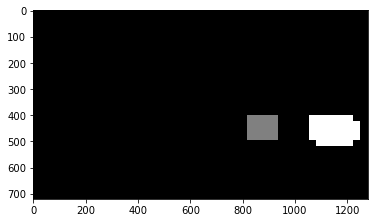

In [90]:
heatmap = np.zeros_like(img[:,:,0])
heatmap = add_heat(heatmap, pos_wndws)
heatmap = apply_threshold(heatmap, 1)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [93]:
def full_image_pipeline(image):
    
    ystart = 400
    ystop = 656
    
    # 1. detect cars
    positive_boxes = find_cars(image, ystart = ystart, ystop = ystop, scale = 1.5, svc= linear_svc, X_scaler = X_scaler,
                               orient = 9, pix_per_cell = 8, cell_per_block = 2, hog_channels = 'ALL',
                               spatial_size = (32, 32), hist_bins = 32)
    # 2. filter detections
    filtered_boxes = filter_bboxes(image, positive_boxes, threshold = 2)

    # 3. draw boxes
    draw_img = image.copy()
    for top_corner, bottom_corner in filtered_boxes:
        cv2.rectangle(draw_img, top_corner, bottom_corner, (0,0,255), 6)
    
    return draw_img

In [94]:
video_output = 'result.mp4'
clip1 = VideoFileClip("test_video.mp4")#.subclip(1,4)
white_clip = clip1.fl_image(full_image_pipeline) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 97%|█████████▋| 38/39 [00:47<00:01,  1.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

